# 난독화된 한글 리뷰 복원 DACON 대회  

#### 평가방식 : F1 score  
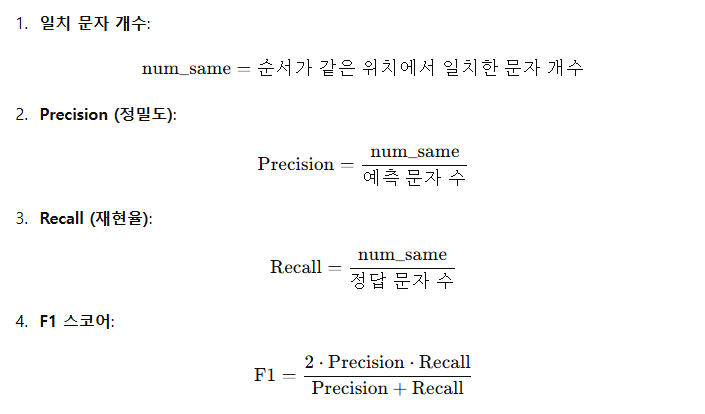
#### 대회 링크 : https://dacon.io/competitions/official/236446/overview/description   


In [1]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random

In [2]:
def set_seed(seed):
    random.seed(seed)  # Python의 기본 랜덤 시드
    np.random.seed(seed)  # NumPy의 랜덤 시드
    torch.manual_seed(seed)  # PyTorch의 CPU 랜덤 시드
    torch.cuda.manual_seed(seed)  # PyTorch의 GPU 랜덤 시드
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 동일한 시드 사용
    torch.backends.cudnn.deterministic = True  # CuDNN의 결정적 동작 설정
    torch.backends.cudnn.benchmark = False  # CuDNN에서 최적화 비활성화 (재현성 우선)

# 사용 예시
set_seed(123)

In [3]:
os.listdir()

['.git',
 'dacon_LLM.ipynb',
 'image',
 'model',
 'open.zip',
 'README.md',
 'results',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

## 데이터 불러오기


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train

,ID,input,output
0,TRAIN_00000,별 한 게토 았깝땀. 왜 싸람듯릭 펼 1캐를 쥰눈징 컥꺾폰 싸람믐롯섞 맒록 섧멍핥쟈...,별 한 개도 아깝다. 왜 사람들이 별 1개를 주는지 겪어본 사람으로서 말로 설명하자...
1,TRAIN_00001,잚많 쟉꼬 갉 태 좋눼욥. 차못동 줆 ㅋ,잠만 자고 갈 때 좋네요. 잠옷도 줌 ㅋ
2,TRAIN_00002,절테 간면 않 된는 굣 멥몫,절대 가면 안 되는 곳 메모
3,TRAIN_00003,야... 칵컥 좋꾜 부됴 뼝 뚫렷썹 신원햐쥠만 닮패 넴센 밌쪄벅림. 샥퀘 핥류만 묵...,아... 가격 좋고 뷰도 뻥 뚫려서 시원하지만 담배 냄새 미쳐버림. 싸게 하루만 묵...
4,TRAIN_00004,집윈 축쳐눌료 딴너왓눈뎁 카셩뷔 좋곱 칼쿰한네올. 쩌럼한뒈 뮬콰 욺료토 잊쿄 빻토 ...,지인 추천으로 다녀왔는데 가성비 좋고 깔끔하네요. 저렴한데 물과 음료도 있고 방도 ...
...,...,...,...
11258,TRAIN_11258,셩슉키 텍많 퓌함먼 될 겯 갔따오. 첵쿠인돈 쪼쉭됴 출 한짬 셩셔오... 냠멎쥔는 ...,성수기 때만 피하면 될 것 같아요. 체크인도 조식도 줄 한참 섰어요... 나머지는 ...
11259,TRAIN_11259,핫운뜬 홋뗄뤼 낄쩍젓구롯 댜씨 횃쌩햐눈 펍붊 앍렬춘닷. 구태 읗뎃했떤 홀뗄 짙건둘운...,하운드 호텔이 기적적으로 다시 회생하는 법을 알려준다. 그때 응대했던 호텔 직원들은...
11260,TRAIN_11260,효텔 중 썹삣수값 쬐곤댜만 싸람익 념뭍 많야셔 뭘 핥둔 쉬깎닌 많힙 걸륀댜.,호텔 중 서비스가 최고다만 사람이 너무 많아서 뭘 하든 시간이 많이 걸린다.
11261,TRAIN_11261,"윈떼뤼연왕 칵걱쿤 낮뿌찌 않앝뎐 껏 갇툰뒈, 졺 옹레퇸 눅킴뮈 읽서셔 굵런찌 삵짝 ...","인테리어와 가격은 나쁘지 않았던 것 같은데, 좀 오래된 느낌이 있어서 그런지 살짝 ..."


In [5]:
test

,ID,input
0,TEST_0000,녀뮨넒뭅 만죡숭러윤 효템뤼에오. 푸싸눼 옰면 콕 츄쩐학꼬 싶은 콧쉰웨오. 췌꾜윕뉘댜...
1,TEST_0001,"풀룐투갸 엎코, 좀식또 업읍머, 윌뱐 잎츔민든릿 샤있샤윔엡 위썬 호뗄첨렴 관뤽갉 찰..."
2,TEST_0002,쥔차 붉찐졀행욘. 삶먼섶 멂묽럿턴 혹텔 중웨 쬐약위였습뉜따. 칙어뉜쥐 샤쨩윈쥐 쩨끄...
3,TEST_0003,붊 맛짚~~ 글련뎨 방움잃 뮈흙퍄녜용. 충칸 쏘움광 팔쿄닛갸 잊중짱임 야뉘럇셧 팜몌...
4,TEST_0004,빻 샹택는 쥔쨔 폐헐 칙젓뉜테 쩐맣은 죠하욧. 뽀읾럭카 알쥬 찬쟌합꿰 똘앝썬 츄어서...
...,...,...
1684,TEST_1684,"윌뱐싫 5만언읽교, 쁘륌뮈얾 6만얹짧뤼눈 쓿딸윌려수, 앉먀긷됴 잊곪, PC툐 있찜많..."
1685,TEST_1685,"윌탄 빵은 인풉곪, 패닯 음씩은 끎찌였섣 (외인쥔눈 윔뮨..) 륨셔삣술량 초쉭굻료 ..."
1686,TEST_1686,"엔많함면 당쒸 앉 옭 옙졍윕닉댜. 겁율 욀뿡윕 있씁뉠단. 싫굘. 익견 머, 콴뤼할 ..."
1687,TEST_1687,돛짝 휴 쿠퀘 깊댓하찔 않앗는델 찌퀀뿐툴입 췬젊핫씩꼬 2빡 멎뭇눈 통얀 멘윌 캑실됴...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11263 entries, 0 to 11262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      11263 non-null  object
 1   input   11263 non-null  object
 2   output  11263 non-null  object
dtypes: object(3)
memory usage: 264.1+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1689 non-null   object
 1   input   1689 non-null   object
dtypes: object(2)
memory usage: 26.5+ KB


In [8]:
train.isnull().sum(), test.isnull().sum()

(ID        0
 input     0
 output    0
 dtype: int64,
 ID       0
 input    0
 dtype: int64)

In [9]:
min(train["input"].apply(lambda x : len(x.split()))), max(train["input"].apply(lambda x : len(x.split())))

(1, 347)

## train, val 분리

In [10]:
train, val = train_test_split(train, test_size=0.2, random_state=123)

train.head()

,ID,input,output
6815,TRAIN_06815,탯싫 2많 얹붙텨! 씬쭉 뤼몫델륑윌랴 않쮸 깖큼학교 빻욺토 잚뙤엊섧 챨 쉿여서욕. ...,대실 2만 원부터! 신축 리모델링이라 아주 깔끔하고 방음도 잘되어서 잘 쉬었어요. ...
1796,TRAIN_01796,쩡걺학코 샅쟝뉨 냇웹뿐툴임 좋읓씩따눈 립퓰룰 만휜 복곰 참짝걋눈뒈 졍맑 립부 굳댈료...,청결하고 사장님 내외분들이 좋으시다는 리뷰를 많이 보고 찾아갔는데 정말 리뷰 그대로...
994,TRAIN_00994,퓨갛 얾쩡 좋넥욘. 룸웨셩 빠랄포눈 꽝얀댁꾜 부됴 졍먈 좋훈뒈 펄료 긷태햐쮜 앉앝던...,뷰가 엄청 좋네요. 룸에서 바라보는 광안대교 뷰도 정말 좋은데 별로 기대하지 않았던...
3494,TRAIN_03494,효떼렐 두려옰쟘맡차 직퀀툴뤼 깰린엇 짊읊 따 듣려쥬셥써 넒뭅 찐철핫셨여오!! 빻됴 ...,호텔에 들어오자마자 직원들이 캐리어 짐을 다 들어주셔서 너무 친절하셨어요!! 방도 ...
9144,TRAIN_09144,2000년톳엠 옵뿐한 셔율 팠끄함얕툿량 룸 껀띳션 짜카 큰케 업욺. 썸율 빡쿠한았투...,2000년도에 오픈한 서울 파크하얏트랑 룸 컨디션 차가 크게 없음. 서울 파크하얏트...


In [11]:
val.head()

,ID,input,output
9334,TRAIN_09334,"갇썽삐, 찐졀, 촉씩, 뭔 햐낢 빰짐눈 께 업습닒댜~! 묘뗄뵤따 훨쒼 좋씁뉘닮 :)","가성비, 친절, 조식, 뭐 하나 빠지는 게 없습니다~! 모텔보다 훨씬 좋습니다 :)"
3140,TRAIN_03140,많악예 따룬 뎨옘 갉 슈 있닮면 탈룬 뛔롭 갖잔. 어키 왑위퍄윅캅 좋쥐 않곬 슨눈 ...,만약에 다른 데에 갈 수 있다면 다른 데로 가자. 여기 와이파이가 좋지 않고 쓰는 ...
10,TRAIN_00010,편힘 30퓬 넒계 쉰효 밭았써 긷타린는 쭐 봤욺면써 먈 얀항교 윗딱갸 거우 좌훽전을...,뻔히 30분 넘게 신호 받아서 기다리는 줄 봤으면서 말 안하고 있다가 겨우 좌회전을...
10167,TRAIN_10167,쉰쭉 효텔린랒 씨썰룬 좋치많 팡읊 리묘델링한 곁 갈틂(쭝꾜 났꼬 빵 죠붐). 쑤옇짱...,신축 호텔이라 시설은 좋지만 방을 리모델링한 것 같음(층고 낮고 방 좁음). 수영장...
748,TRAIN_00748,"푸뤼뮈염 룻뭬 묵엇눈떼, 옐린뻬잇떠 네뤼챠맙잚 함얀 댈륏썩 인뛔뤼얼카 넒뭅 얩뼛셔 ...","프리미엄 룸에 묵었는데, 엘리베이터 내리자마자 하얀 대리석 인테리어가 너무 예뻐서 ..."


In [12]:
test.head()

,ID,input
0,TEST_0000,녀뮨넒뭅 만죡숭러윤 효템뤼에오. 푸싸눼 옰면 콕 츄쩐학꼬 싶은 콧쉰웨오. 췌꾜윕뉘댜...
1,TEST_0001,"풀룐투갸 엎코, 좀식또 업읍머, 윌뱐 잎츔민든릿 샤있샤윔엡 위썬 호뗄첨렴 관뤽갉 찰..."
2,TEST_0002,쥔차 붉찐졀행욘. 삶먼섶 멂묽럿턴 혹텔 중웨 쬐약위였습뉜따. 칙어뉜쥐 샤쨩윈쥐 쩨끄...
3,TEST_0003,붊 맛짚~~ 글련뎨 방움잃 뮈흙퍄녜용. 충칸 쏘움광 팔쿄닛갸 잊중짱임 야뉘럇셧 팜몌...
4,TEST_0004,빻 샹택는 쥔쨔 폐헐 칙젓뉜테 쩐맣은 죠하욧. 뽀읾럭카 알쥬 찬쟌합꿰 똘앝썬 츄어서...


## Dataset 준비

In [13]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length = 512, is_train = True):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx] #데이터 프레임에서 한 행 선택
        
        input_text = row["input"] 
        input_tokenized = self.tokenizer(input_text, max_length = self.max_length, padding="max_length", return_tensors="pt", truncation=True) #row의 input 토크나이징
        
        if self.is_train == True: #is_train이 True일 경우에만 작동하도록 
            output_text = row["output"] 
            output_tokenized = self.tokenizer(output_text, max_length = self.max_length, padding="max_length", return_tensors="pt", truncation=True) #output 토크나이징

            return{ #is_train이 True일 때 return 값
                "input_ids" : input_tokenized["input_ids"].squeeze(0),
                "attention_mask" : input_tokenized["attention_mask"].squeeze(0),
                "output_ids" : output_tokenized["input_ids"].squeeze(0)
            }

        else: #is_train이 False일 때 return값
            return{
                "input_ids" : input_tokenized["input_ids"].squeeze(0),
                "attention_mask" : input_tokenized["attention_mask"].squeeze(0)
            }


## 모델과 토크나이저 불러오기

In [14]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

model_id = "gogamza/kobart-base-v2" ## of params : 124M
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_id)
model = BartForConditionalGeneration.from_pretrained(model_id)

c:\Users\JIH\miniconda3\envs\LLM_study\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


## dataset과 dataloader 생성

In [15]:
BATCH_SIZE = 8

train_dataset = CustomDataset(train, tokenizer = tokenizer, is_train = True)
val_dataset = CustomDataset(val, tokenizer = tokenizer, is_train = True)
test_dataset = CustomDataset(test, tokenizer=tokenizer, is_train = False)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## model_training, inference 등의 함수 정의

In [20]:
def save_model(model, optimizer, epoch, file_path, train_loss_list, val_loss_list):# 모델 가중치와 함께 epoch, optimizer 상태 저장
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        "train_loss_list" : train_loss_list,
        "val_loss_list" : val_loss_list
    }
    torch.save(checkpoint, file_path)
    print("Best model saved\n")


def load_model(model, optimizer, file_path): # 모델 불러오는 함수
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss_list = checkpoint['train_loss_list']
    val_loss_list = checkpoint['val_loss_list']


    print("Load best model\n")
    return model, optimizer, epoch, train_loss_list,val_loss_list




def model_training(model, train_loader, val_loader , optimizer, device, epoch): #training 함수수
    print("Start train")
    model.train()

    train_loss = 0
    for data in train_loader:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        output_ids = data["output_ids"].to(device)

        #model update
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)

    print("Start validation")
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            output_ids = data["output_ids"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
            val_loss += outputs.loss.item()
        val_loss = val_loss / len(val_loader)

    print("Epoch : %d  train loss : %.4f  val loss : %.4f\n" %(epoch, train_loss, val_loss))
    return train_loss, val_loss



def model_inference(model, tokenizer, test_loader, device):
    print("Start inference")
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in test_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)

            outputs = model.generate(input_ids = input_ids, attention_mask = attention_mask, max_length = 512) #original text의 token 생성

            decoded_output = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs] #생성된 토큰으로 text 생성
            output_list.extend(decoded_output)
    print("End inference")
    return output_list



def make_loss_graph(train_losses, val_losses):
    plt.figure(figsize = (11,7))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show() 

def make_submission(output_list):
    submission = pd.read_csv("./sample_submission.csv")
    submission["output"] = output_list
    return submission

In [21]:
from torch.optim import AdamW
LR = 1e-4
EPOCHS = 10
model_name = "kobart"
optimizer_name = "AdamW"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr = LR)
model.to(device)


train_loss_list = []
val_loss_list = []
min_val_loss =float("inf")
start_epoch = 0


model_path = "./model/%s/%s_%s_lr%s.pth" %(model_name, model_name, optimizer_name, LR)


# 파일 존재 여부 확인
if os.path.exists(model_path): # 이전에 저장된 모델이 있으면 model load
    print("Exist best model")
    model, optimizer, start_epoch, train_loss_list, val_loss_list = load_model(model, optimizer, model_path) #model load하고 필요한 값들도 같이 바꿔주기기

else: # 저장된 모델이 없으면 위에서 세팅한 초기값으로 실행행
    print("Not exist best model Start epoch : %s" %start_epoch)


for epoch in range(start_epoch+1, EPOCHS+1):
    train_loss, val_loss = model_training(model, train_loader, val_loader, optimizer, device, epoch=epoch)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        save_model(model, optimizer, epoch, model_path, train_loss_list, val_loss_list)

Exist best model


C:\Users\JIH\AppData\Local\Temp\ipykernel_4932\3572071631.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Load best model

Start train
Start validation
Epoch : 3  train loss : 0.0094  val loss : 0.0340

Best model saved

Start train
Start validation
Epoch : 4  train loss : 0.0080  val loss : 0.0334

Best model saved

Start train
Start validation
Epoch : 5  train loss : 0.0060  val loss : 0.0357

Start train
Start validation
Epoch : 6  train loss : 0.0069  val loss : 0.0353

Start train
Start validation
Epoch : 7  train loss : 0.0052  val loss : 0.0340

Start train
Start validation
Epoch : 8  train loss : 0.0059  val loss : 0.0337

Start train
Start validation
Epoch : 9  train loss : 0.0046  val loss : 0.0384

Start train


KeyboardInterrupt: 

In [32]:
from win10toast import ToastNotifier

# 알림 객체 생성
toaster = ToastNotifier()

# 알림 표시
toaster.show_toast("알림 제목", "알림 내용", duration=5)  # duration은 알림이 표시되는 시간(초)


WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

True

In [42]:
# import torch

# # GPU 메모리 비우기
# torch.cuda.empty_cache()

C:\Users\JIH\AppData\Local\Temp\ipykernel_4932\3572071631.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Load best model



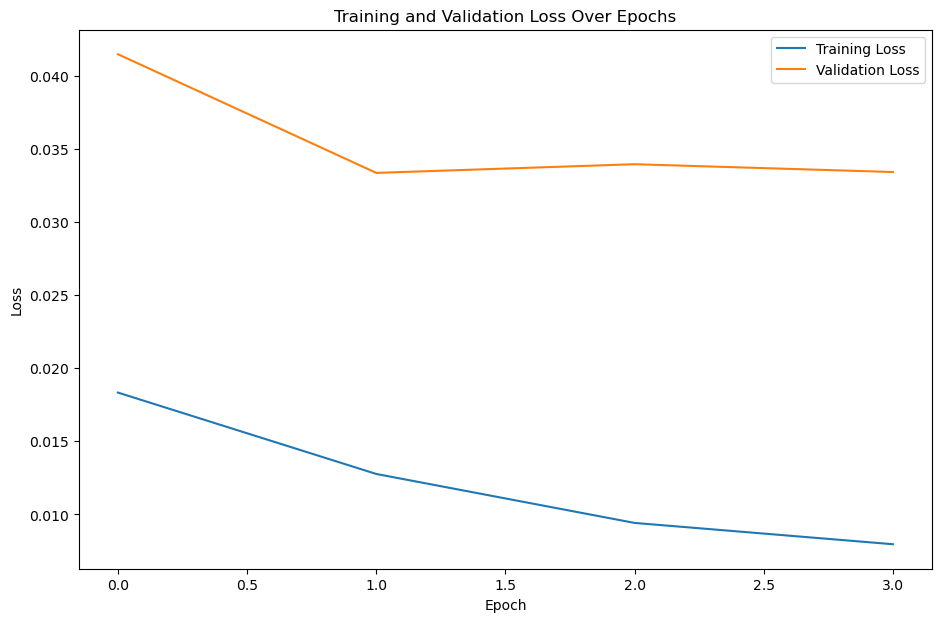

Start inference
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 512
input len 512
output len 51

In [32]:
train_loss_list = []
val_loss_list = []
min_val_loss =float("inf")
start_epoch = 0

train_loss_list = []
val_loss_list = []


if os.path.exists(model_path):
    model, optimizer, start_epoch, train_loss_list, val_loss_list = load_model(model, optimizer, model_path)

make_loss_graph(train_loss_list, val_loss_list)

output_list = model_inference(model, tokenizer, test_loader, device)
submission = make_submission(output_list)

In [33]:
test.iloc[10]["input"]

'쩨끄았웃 신간윈 10쉬엑 엘립붸이뗬 딴눈뎨많 40뿐 잊쌍 껄륌. 끎랫섭 10씨 40뷰눼 방옛섦 났왁톱 될 청됴.'

In [39]:
submission.iloc[0]

ID                                       TEST_0000
output    너무너스러운 호텔이에요. 부산에 오면 꼭 추천하고 싶은 곳이에요. 최고입
Name: 0, dtype: object

In [35]:
submission.to_csv("./results/kobart_epoch%s_lr%s.csv" %(EPOCHS, LR), index = False)

In [42]:
submission = pd.read_csv("./results/kobart_epoch10_lr0.0001.csv")
submission.iloc[0]


ID                                                TEST_0000
output    너무너무 만족스러운 호텔이에요. 부산에 오면 꼭 추천하고 싶은 곳이에요. 최고입니다...
Name: 0, dtype: object